In [1]:
import numpy as np
import sys
import json
import time
import datetime

import scipy.io
import scipy.ndimage as snd
from scipy.stats import moment
from scipy.optimize import curve_fit

try:
    from epics import caget, caput
except:
    print("did not import epics")
    
from image import Image
from emittance_calc import get_normemit

import matplotlib.pyplot as plt

In [2]:
# get PV info
pv_info = json.load(open('pv_info.json'))

im_pv = pv_info['device']['OTR2']['image']
n_col_pv = pv_info['device']['OTR2']['ncol']
n_row_pv = pv_info['device']['OTR2']['nrow']

meas_input = pv_info['device']['QUAD']['Q525']
varx_pv = pv_info['device']['SOL']['SOL121']
vary_pv = pv_info['device']['QUAD']['Q121']
varz_pv = pv_info['device']['QUAD']['Q122']

energy = caget(pv_info['energy']['DL1'])
resolution = caget(pv_info['device']['OTR2']['resolution'])*1e-6

In [26]:
# change quad function
def setquad(value):
    """Sets Q525 to new scan value"""
    caput(meas_input, value)
    
def saveimage(im, ncol, nrow):
    timestamp = (datetime.datetime.now()).strftime("%m-%d_%H-%M-%S")
    np.save(f'./saved_images/img_{timestamp}.npy', im)
    np.save(f'./saved_images/ncol_{timestamp}.npy', ncol)
    np.save(f'./saved_images/nrow_{timestamp}.npy', nrow)
    
# get beamsizes function at current quad setting
def getbeamsizes():
    """Returns xrms, yrms, xrms_err, yrms_err"""
    im, ncol, nrow = caget(im_pv), caget(n_col_pv), caget(n_row_pv)
    
    saveimage(im, ncol,nrow)
    
    beam_image = Image(im, ncol, nrow, bg_image = None)
    beam_image.reshape_im()
    beam_image.subtract_bg()
    beam_image.get_im_projection()
    return beam_image.get_sizes(show_plots=True)

In [9]:
# example quad list
quad_list = [-5, -4, -3, -2]
xrms_list = []
yrms_list = []

for quad in quad_list:
    setquad(quad)
    time.sleep(3)
    beamsizes = getbeamsizes()[0:2]*resolution #convert to meters
    xrms_list.append(beamsizes[0])
    yrms_list.append(beamsizes[1])

# Compute and return emittance using quad_list and beamsizes_list
emittance = get_normemit(energy, quad_list, xrms, yrms, show_plots=False)
print(emittance/1e-6)

## Backup option to get beamsizes

In [ ]:
# open ProfMon GUI and select "show stats"
xrms_profmon = caget('OTRS:IN20:571:XRMS')
yrms_profmon = caget('OTRS:IN20:571:YRMS')

## Testing emit fn

In [3]:
energy

0.135

In [3]:
quad = [-5.38210006, -4.24154984, -3.71824052, -3.17573903, -1.99949716] 
xrms = [1.59568569e-04, 8.75908038e-05, 6.55396626e-05, 4.85704395e-05, 7.99284069e-05]
yrms = [9.65669677e-05, 5.61440470e-05, 4.89721770e-05, 4.80127438e-05, 5.86293035e-05]

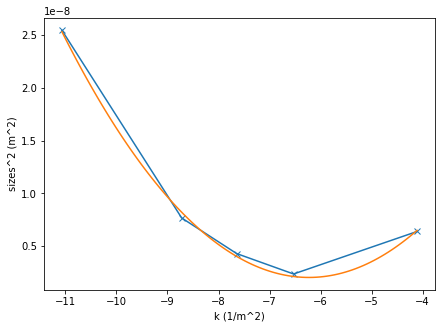

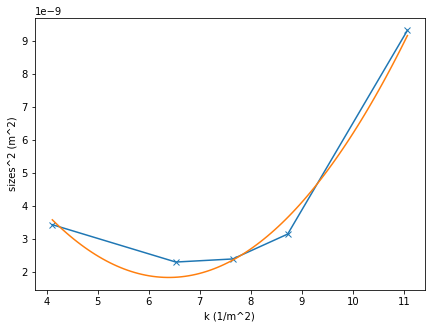

5.060068027327388e-07

In [4]:
get_normemit(energy, quad, xrms, yrms, show_plots=True)